In [90]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\ximfa\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [91]:
salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [92]:
salary.columns=['salary']

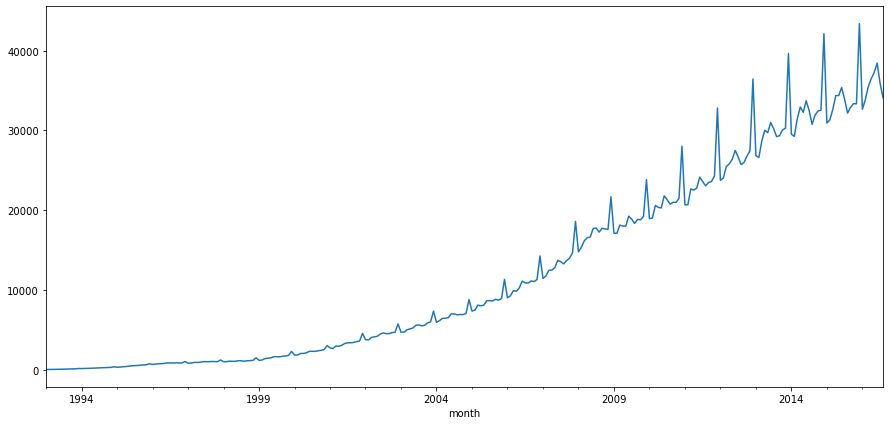

In [93]:
salary.salary.plot(figsize=(15,7))

#### Видно, что во времени увеличивается дисперсия, наблюдается ярко выраженная годовая сезонность

## 1) Избавимся от гетероскедантичности

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


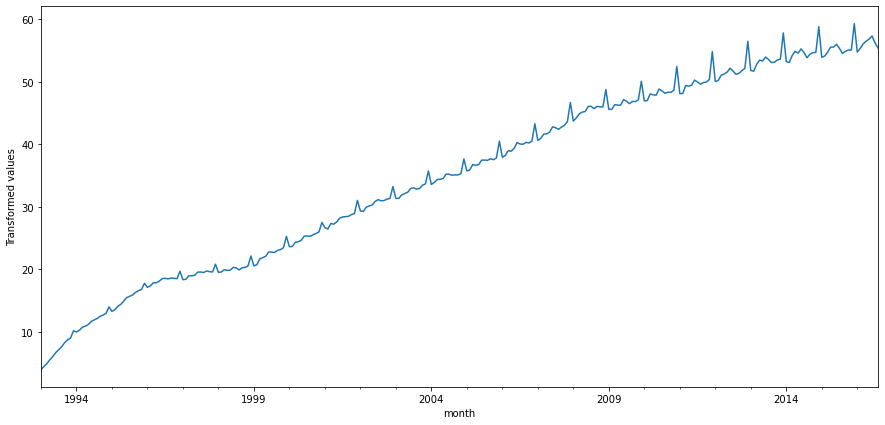

In [94]:
salary['salary_box'], lmbda = stats.boxcox(salary.salary)
plt.figure(figsize(15,7))
salary['salary_box'].plot()
plt.ylabel(u'Transformed values')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['salary_box'])[1])

## 2) Проведем STL декомпозицию ряда

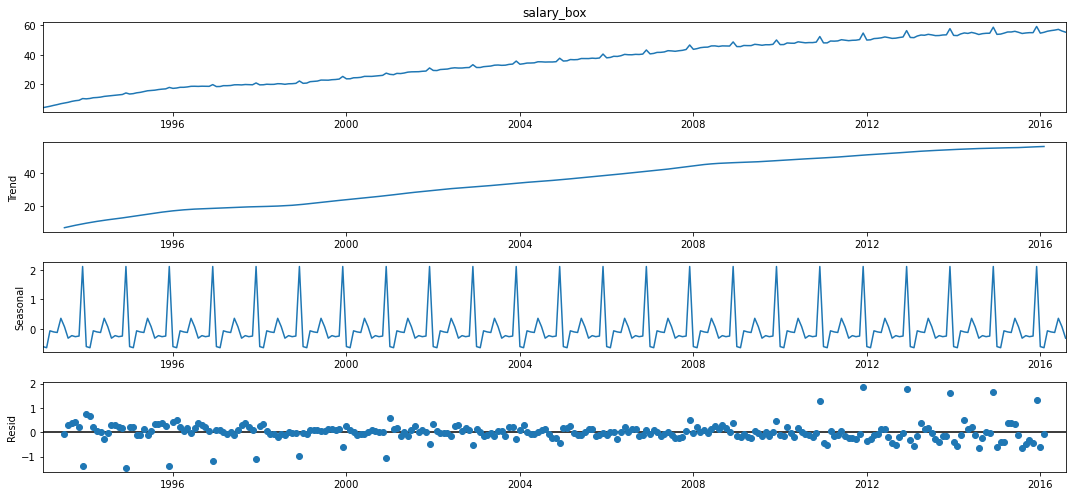

Критерий Дики-Фуллера: p=0.696899


In [95]:
sm.tsa.seasonal_decompose(salary['salary_box']).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['salary_box'])[1])

## 3) Проведем сезонное дифференцирование

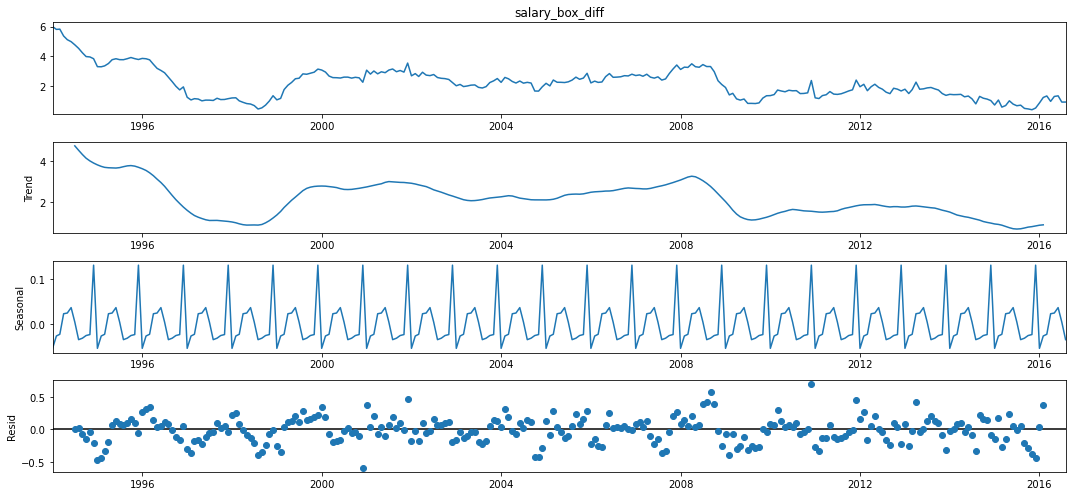

Критерий Дики-Фуллера: p=0.014697


In [96]:
salary['salary_box_diff']=salary.salary_box.diff(12)
sm.tsa.seasonal_decompose(salary['salary_box_diff'][12:]).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['salary_box_diff'][12:])[1])

#### Избавиться от тренда не удалось. Проведем обычное дифференцирование

## 4) Обычное дифференцирование

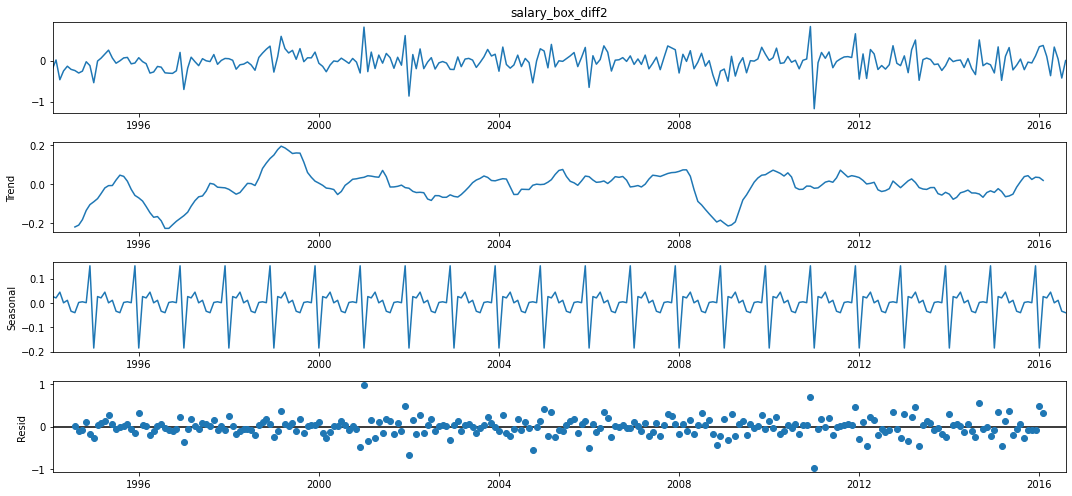

Критерий Дики-Фуллера: p=0.000000


In [97]:
salary['salary_box_diff2']=salary.salary_box_diff.diff(1)
sm.tsa.seasonal_decompose(salary['salary_box_diff2'][13:]).plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary['salary_box_diff2'][13:])[1])

#### Нам удалось привести ряд к стационарному

## 5) Оценим p,P, q,Q

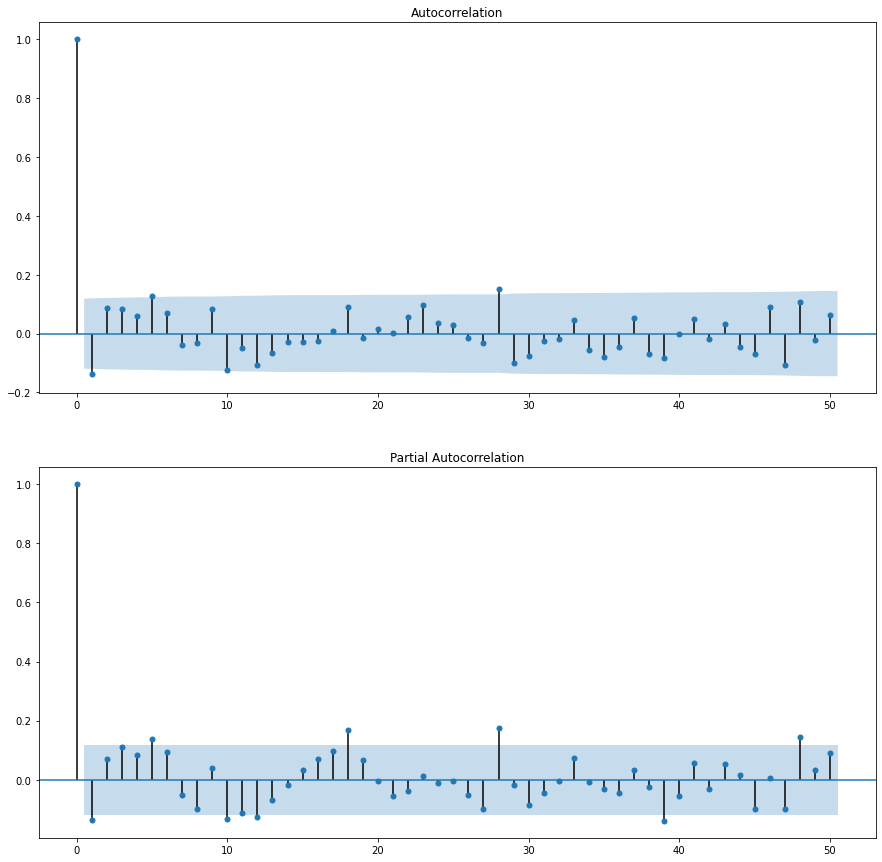

In [98]:
fig, ax = plt.subplots(2,1,figsize=(15,15))
sm.graphics.tsa.plot_acf(salary['salary_box_diff2'][13:].values.squeeze(), lags=50, ax=ax[0])
sm.graphics.tsa.plot_pacf(salary['salary_box_diff2'][13:].values.squeeze(), lags=50, ax=ax[1])
plt.show()

### Начальное приближение

Q=0, q=1, P=1, p=10

In [110]:
ps = range(0, 11)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [112]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

66

In [113]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Wall time: 2min 15s


In [114]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
16  (2, 2, 0, 0) -21.488595
17  (2, 2, 1, 0) -21.473461
22  (3, 2, 0, 0) -20.263316
23  (3, 2, 1, 0) -20.125276
28  (4, 2, 0, 0) -18.868355


In [115]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                          salary_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  15.744
Date:                             Mon, 15 Feb 2021   AIC                            -21.489
Time:                                     21:24:53   BIC                             -3.478
Sample:                                 01-01-1993   HQIC                           -14.257
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4855      0.044     33.955      0.000       1.400       1.571
ar.L2         -0.6838      

## 6) Анализ остатков

Критерий Стьюдента: p=0.269825
Критерий Дики-Фуллера: p=0.000000


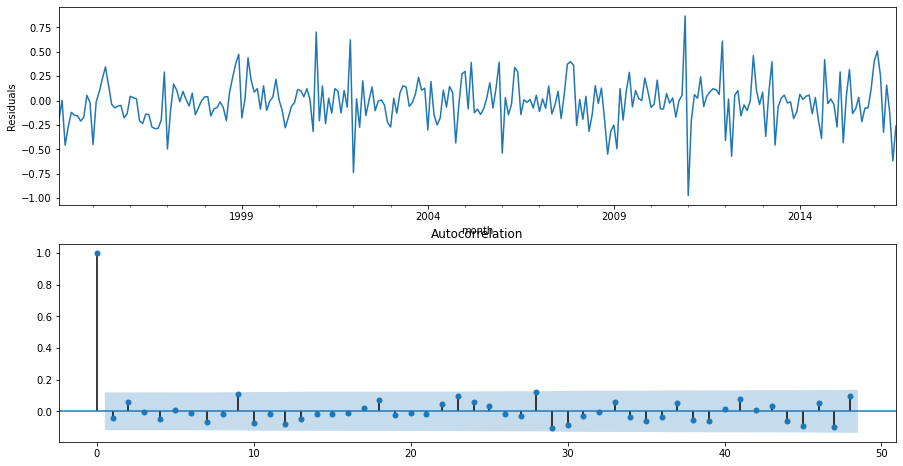

In [116]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены. Переходим к проверке предсказаний

## 7) Проверка предсказаний

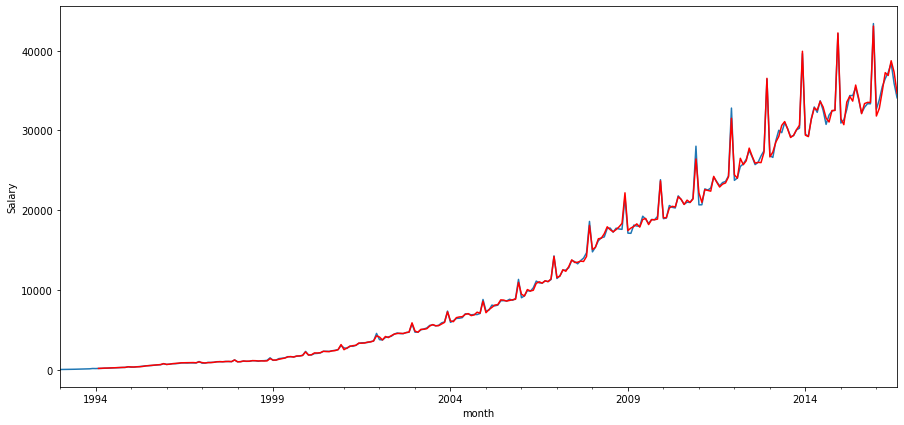

In [117]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
salary.salary.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

#### Модель отлично воспроизводит исторические данные

## 8) Прогноз

In [118]:
salary2 = salary[['salary']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])

In [119]:
start=np.where(np.isnan(salary2.salary.values)==True)[0][0]

In [120]:
end=np.where(np.isnan(salary2.salary.values)==True)[0][-1]

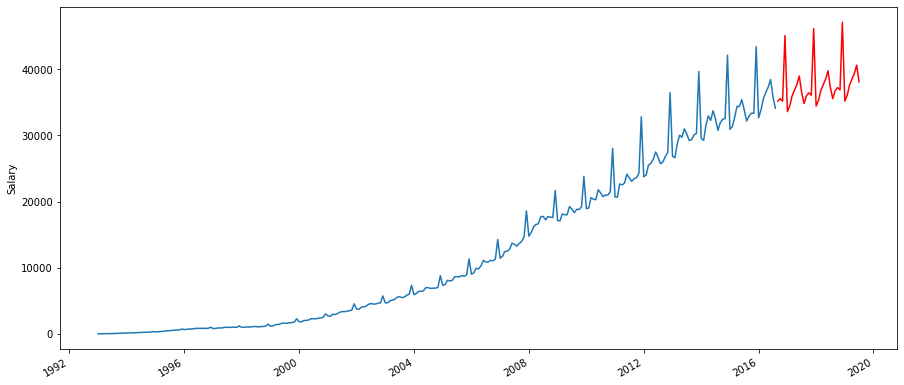

In [121]:
salary2['forecast'] = invboxcox(best_model.predict(start=start, end=end), lmbda)

plt.figure(figsize(15,7))
salary2.salary.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()